## 模块导入

In [1]:
import tensorflow as tf
import gzip
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import os

tf.__version__

'1.15.2'

## gzip 使用

In [2]:
with open('gzip_demo/demo', 'rb') as plain_file:
    with gzip.open('gzip_demo/demo.gz', 'wb') as zip_file:
        zip_file.writelines(plain_file)

In [3]:
with gzip.open('gzip_demo/demo.gz') as g:
    print('读取 gz 文件:', g.read().decode('utf-8'))

读取 gz 文件: how to use gzip


## 数据读取方式一
**官网读取方式**

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./dataset_download/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./dataset_download/mnist/train-labels-idx1-ubyte.gz
Extracting ./dataset_download/mnist/t10k-images-idx3-ubyte.gz
Extracting ./dataset_download/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.
train images shape: (55000, 784) 
train labels shape: (55000,)


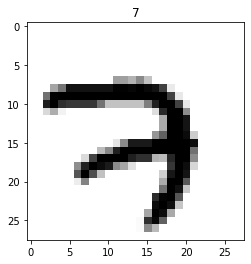

In [4]:
mnist = input_data.read_data_sets('./dataset_download/mnist/', one_hot=False)

print('train images shape:', mnist.train.images.shape,
      '\ntrain labels shape:', mnist.train.labels.shape)

plt.imshow(mnist.train.images[0].reshape(28, 28), cmap='binary')
plt.title(str(mnist.train.labels[0]))

plt.show()

可以利用 fake_data=True 来 返回空列表数据

In [5]:
mnist = input_data.read_data_sets('./dataset_download/mnist/', fake_data=True, one_hot=False)
print('train images:', mnist.train.images,
      '\ntrain labels:', mnist.train.labels,
      '\nvalidation images:', mnist.validation.images,
      '\nvalidation labels:', mnist.validation.labels,
      '\ntest images:', mnist.test.images,
      '\ntest labels:', mnist.test.labels)

train images: [] 
train labels: [] 
validation images: [] 
validation labels: [] 
test images: [] 
test labels: []


## 数据获取方式二

定义大尾（big endian）存放方式

In [6]:
def read32(bytestream):
    dt = np.dtype(np.uint32).newbyteorder('>')
    
    return np.frombuffer(bytestream.read(4), dtype=dt)[0]

将 magic number=2051 作为图像文件在读取时的判断条件，读取的数据通过 `data = np.frombuffer(buf, dtype=np.uint8)` 转换成 numpy 数组，这是只有一个维度的数据，通过 `data = data.reshape(num_images, rows, cols, 1)` 获取 28×28 形式的数据

In [7]:
def extract_images(f):

    print('Extracting', f.name)
    with gzip.GzipFile(fileobj=f) as bytestream:
        magic = read32(bytestream)
        if magic != 2051:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' %
                             (magic, f.name))
        num_images = read32(bytestream)
        rows = read32(bytestream)
        cols = read32(bytestream)
        buf = bytestream.read(rows * cols * num_images)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, rows, cols, 1)

        return data

one_hot 编码
dense_to_one_hot() 是官网使用的独热编码函数，one_hot() 则是重新定义的独热编码函数

In [8]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1

    return labels_one_hot

In [9]:
from sklearn.preprocessing import OneHotEncoder

def one_hot(labels):
    encoder = OneHotEncoder(sparse=False)

    one_hot = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]
    encoder.fit(one_hot)
    labels_reshape = labels.reshape(-1, 1)
    labels_onehot = encoder.transform(labels_reshape)
    
    return labels_onehot

将 magic number=2049 作为标签文件在读取时的判断条件  
这里在 `if not_hot`: 判定中使用 `one_hot()` 函数代替 `dense_to_one_hot()`

In [10]:
def extract_labels(f, one_hot=False):

    print('Extracting', f.name)
    with gzip.GzipFile(fileobj=f) as bytestream:
        magic = read32(bytestream)
        if magic != 2049:
            raise ValueError('Invalid magic number %d in MNIST label file: %s' %
                             (magic, f.name))
        num_items = read32(bytestream)
        buf = bytestream.read(num_items)
        labels = np.frombuffer(buf, dtype=np.uint8)

        if one_hot:
            return one_hot(labels)

        return labels

读取单个图像文件与单个标签文件
也可以不导入 gfile 包，将下面的 with 结构如下调换也能运转

`with open(local_file, 'rb') as f:`   
&ensp;&ensp;&ensp;&ensp;`train_images = extract_images(f)`

In [11]:
from tensorflow.python.framework import dtypes
from tensorflow.python.platform import gfile

def read_data_sets(one_hot=False,
                   dtype=dtypes.float32,
                   reshape=True,
                   seed=None):

    local_image_file = 'dataset_download/mnist/train-images-idx3-ubyte.gz'
    with gfile.Open(local_image_file, 'rb') as f:
        train_images = extract_images(f)
    
    local_label_file = 'dataset_download/mnist/train-labels-idx1-ubyte.gz'
    with gfile.Open(local_label_file, 'rb') as f:
        train_labels = extract_labels(f)

    return train_images, train_labels

In [12]:
train_images, train_labels = read_data_sets()

Extracting dataset_download/mnist/train-images-idx3-ubyte.gz
Extracting dataset_download/mnist/train-labels-idx1-ubyte.gz


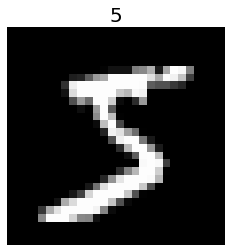

In [13]:
plt.imshow(train_images[0].reshape(28, 28), cmap='gray')
plt.title(train_labels[0], fontsize=20)
plt.axis('off')

plt.show()

In [14]:
train_labels_onehot = one_hot(train_labels)
train_labels_onehot

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [15]:
train_labels_dense_to_one_hot = dense_to_one_hot(train_labels, 10)
train_labels_dense_to_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

### 获取整个Mnist训练集、测试集与验证集

In [16]:
def get_dataset(one_hot=False,
                dtype=dtypes.float32,
                reshape=True,
                validation_size=5000,
                seed=None):

    train_image_file = 'dataset_download/mnist/train-images-idx3-ubyte.gz'
    with gfile.Open(train_image_file, 'rb') as f:
        train_images = extract_images(f)
    
    train_label_file = 'dataset_download/mnist/train-labels-idx1-ubyte.gz'
    with gfile.Open(train_label_file, 'rb') as f:
        train_labels = extract_labels(f)
        
    test_image_file = 'dataset_download/mnist/t10k-images-idx3-ubyte.gz'
    with gfile.Open(test_image_file, 'rb') as f:
        test_images = extract_images(f)    
        
    test_label_file = 'dataset_download/mnist/t10k-labels-idx1-ubyte.gz'
    with gfile.Open(test_label_file, 'rb') as f:
        test_labels = extract_labels(f)    
    
    validation_images = train_images[:validation_size]
    validation_labels = train_labels[:validation_size]
    train_images = train_images[validation_size:]
    train_labels = train_labels[validation_size:]

    return (train_images, train_labels), (test_images, test_labels), (validation_images, validation_labels)

In [17]:
(train_images, train_labels), (test_images, test_labels), (validation_images, validation_labels) = get_dataset()

Extracting dataset_download/mnist/train-images-idx3-ubyte.gz
Extracting dataset_download/mnist/train-labels-idx1-ubyte.gz
Extracting dataset_download/mnist/t10k-images-idx3-ubyte.gz
Extracting dataset_download/mnist/t10k-labels-idx1-ubyte.gz


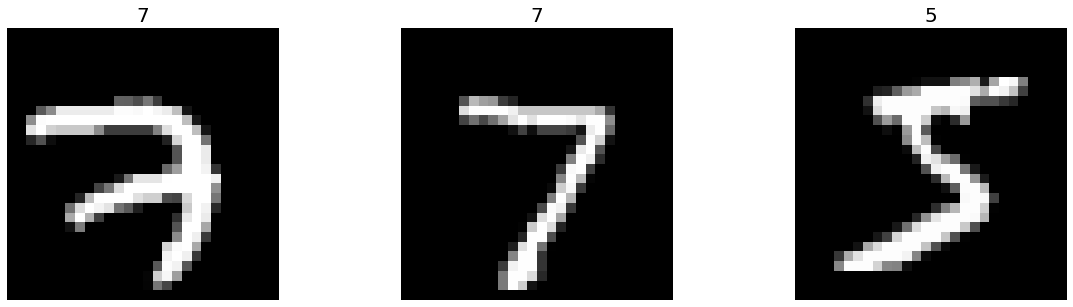

In [18]:
fig = plt.figure(figsize=(20, 5))
image_list = [train_images[0].reshape(28, 28),
              test_images[0].reshape(28, 28),
              validation_images[0].reshape(28, 28)]

label_list = [str(train_labels[0]),
              str(test_labels[0]),
              str(validation_labels[0])]

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(image_list[i], cmap='gray')
    plt.title(label_list[i], fontsize=20)
    plt.axis('off')

plt.show()

### 获取整个 Fashion-Mnist 训练集、测试集与验证集

In [19]:
def get_dataset(one_hot=False,
                dtype=dtypes.float32,
                reshape=True,
                validation_size=5000,
                seed=None):

    train_image_file = 'dataset_download/fashion_mnist/train-images-idx3-ubyte.gz'
    with gfile.Open(train_image_file, 'rb') as f:
        train_images = extract_images(f)
    
    train_label_file = 'dataset_download/fashion_mnist/train-labels-idx1-ubyte.gz'
    with gfile.Open(train_label_file, 'rb') as f:
        train_labels = extract_labels(f)
        
    test_image_file = 'dataset_download/fashion_mnist/t10k-images-idx3-ubyte.gz'
    with gfile.Open(test_image_file, 'rb') as f:
        test_images = extract_images(f)    
        
    test_label_file = 'dataset_download/fashion_mnist/t10k-labels-idx1-ubyte.gz'
    with gfile.Open(test_label_file, 'rb') as f:
        test_labels = extract_labels(f)    
    
    validation_images = train_images[:validation_size]
    validation_labels = train_labels[:validation_size]
    train_images = train_images[validation_size:]
    train_labels = train_labels[validation_size:]

    return (train_images, train_labels), (test_images, test_labels), (validation_images, validation_labels)

In [20]:
(train_images, train_labels), (test_images, test_labels), (validation_images, validation_labels) = get_dataset()

Extracting dataset_download/fashion_mnist/train-images-idx3-ubyte.gz
Extracting dataset_download/fashion_mnist/train-labels-idx1-ubyte.gz
Extracting dataset_download/fashion_mnist/t10k-images-idx3-ubyte.gz
Extracting dataset_download/fashion_mnist/t10k-labels-idx1-ubyte.gz


| 标注编号 | 描述 |
| --- | --- |
| 0 | T-shirt/top（T恤）|
| 1 | Trouser（裤子）|
| 2 | Pullover（套衫）|
| 3 | Dress（裙子）|
| 4 | Coat（外套）|
| 5 | Sandal（凉鞋）|
| 6 | Shirt（汗衫）|
| 7 | Sneaker（运动鞋）|
| 8 | Bag（包）|
| 9 | Ankle boot（踝靴）|

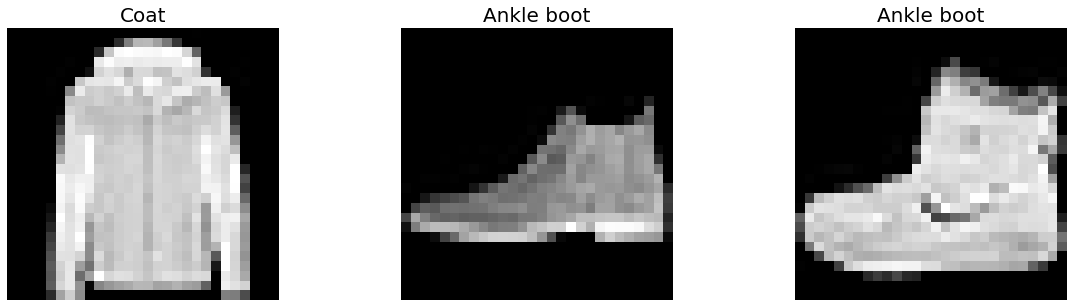

In [21]:
class_dict = {0:'T-shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
              5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

fig = plt.figure(figsize=(20, 5))
image_list = [train_images[0].reshape(28, 28),
              test_images[0].reshape(28, 28),
              validation_images[0].reshape(28, 28)]

label_list = [train_labels[0],
              test_labels[0],
              validation_labels[0]]

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(image_list[i], cmap='gray')
    plt.title(class_dict[label_list[i]], fontsize=20)
    plt.axis('off')

plt.show()

## 数据获取方式三
**本次直接将所有数据串在一起，为后期做 GAN 与 CGAN 做数据读取处理用**，直接在函数内部将文件夹定位到 `dataset_download`，在定义解压函数中，并未使用 magic number 获取数据的方式，而是使用 head_size 即 [offset] 0008 与 0016 的方式获取

In [22]:
def extract_data(filename, num_data, head_size, data_size):
    with gzip.open(filename) as bytestream:
        bytestream.read(head_size)
        buf = bytestream.read(data_size * num_data)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float)
    return data

获取 mnist 图像数据，与上面相同，获取的数据只有一个维度，我们需要将其 reshape 成 28×28 的形式

In [23]:
dataset_name = 'mnist'
data_dir = os.path.join("./dataset_download", dataset_name)
train_images_data = extract_data(data_dir + '/train-images-idx3-ubyte.gz', 60000, 16, 28 * 28)

print('train_images_data shape:', train_images_data.shape)

train_images_data shape: (47040000,)


In [24]:
train_images = train_images_data.reshape(-1, 28, 28, 1)
print('train_images shape:', train_images.shape)

train_images shape: (60000, 28, 28, 1)


解析下方 load_data() 创建 one_hot 的方法，以 10 个类别为例，先创建一个暂存的零矩阵，在遍历修改零矩阵的值

In [25]:
a = np.array([5, 4, 8, 6, 3, 2, 4, 7, 8, 1])
a_one_hot = np.zeros((len(a), 10), dtype=float)

for i, label in enumerate(a):
    a_one_hot[i, label] = 1.0

print('a:\n', a,
      '\na_one_hot:', a_one_hot)

a:
 [5 4 8 6 3 2 4 7 8 1] 
a_one_hot: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [26]:
def load_data(dataset_name, onehot=False):
    data_dir = os.path.join("./dataset_download", dataset_name)

    data = extract_data(data_dir + '/train-images-idx3-ubyte.gz', 60000, 16, 28 * 28)
    train_images = data.reshape((-1, 28, 28, 1))

    data = extract_data(data_dir + '/train-labels-idx1-ubyte.gz', 60000, 8, 1)
    train_labels = data.reshape((-1))

    data = extract_data(data_dir + '/t10k-images-idx3-ubyte.gz', 10000, 16, 28 * 28)
    test_images = data.reshape((-1, 28, 28, 1))

    data = extract_data(data_dir + '/t10k-labels-idx1-ubyte.gz', 10000, 8, 1)
    test_labels = data.reshape((-1))

    train_images = np.asarray(train_images)
    test_labels = np.asarray(test_labels)

    X = np.concatenate((train_images, test_images), axis=0)
    y = np.concatenate((train_labels, test_labels), axis=0).astype(np.int)

    seed = 547
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(y)
    
    if onehot== True:
        y_vec = np.zeros((len(y), 10), dtype=np.float)
        for i, label in enumerate(y):
            y_vec[i, y[i]] = 1.0
        
        return X, y_vec

    return X, y

### 读取整个 Mnist 数据集

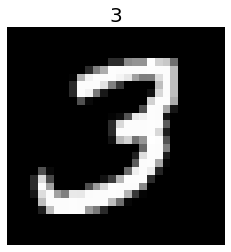

In [27]:
images, labels = load_data('mnist')
plt.imshow(images[520].reshape(28, 28), cmap='gray')
plt.title(str(labels[520]), fontsize=20)
plt.axis('off')
plt.show()

### 读取整个 Fashion-Mnist 数据集

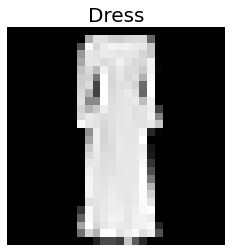

In [28]:
class_dict = {0:'T-shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
              5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

images, labels = load_data('fashion_mnist')
plt.imshow(images[1314].reshape(28, 28), cmap='gray')
plt.title(class_dict[labels[1314]], fontsize=20)
plt.axis('off')
plt.show()